ML Final Project

Spring 2017 - NYU CUSP

Notebook reads in datetime converted CitiBike Data by month (e.g. Jan_citi.csv) from 2016 and converts gets the counts and means per month

Written in Python 2.7 (Anaconda)

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gp
from geopandas import GeoDataFrame
import os
from shapely.geometry import Point
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import IsolationForest
from pandas.tseries.holiday import USFederalHolidayCalendar
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

In [ ]:
proj_folder = os.getcwd()
proj_folder

Check for spurious entires

## Remove spurious trip length rationale

From website: A $101 security deposit hold will be placed on your card when you purchase a pass. If you incur usage

fees, your card will be charged. The fee for a lost or stolen bike is $1200 (+ tax).


## Total Loss: 

Annual pass = 163/year + 101 Security fee + ($ 2.50 * min) = 5616 minutes
 
3 day Pass = 24 + 101 Security fee + ($ 2.50 * 15min) = 4031.25

Day Pass = 12 + 101 Security fee + ($4 * 15min) = 4076.25

Ride = 4 + 101 Security fee + ($4 * 15min) = 4106.25 

So remove anything longer than 5616 minutes, the maximum time before Total Loss and keep trip long than 1 minute

## Aggregate by day and Export

In [ ]:
columns =['bike_date', 'tripduration', 'start station id', 'start station latitude', 'start station longitude', \
          'end station id', 'end station latitude','end station longitude', 'bikeid', 'birth year', \
          'gender', 'start_hour', 'end_hour','bike_trip_count']

In [ ]:
months = ["Jan_citi", "Feb_citi", "Mar_citi", "Apr_citi", "May_citi", "Jun_citi", "Jul_citi", "Aug_citi", \
          "Sep_citi", "Oct_citi", "Nov_citi", "Dec_citi"]

In [ ]:
months2 = ["citibike_201501", "citibike_201502", "citibike_201503", "citibike_201504", "citibike_201505", \
          "citibike_201506", "citibike_201507", "citibike_201508", "citibike_201509", "citibike_201510", \
          "citibike_201511", "citibike_201512"]

In [8]:
# Create Empty dataframe
citi_df_all_day = pd.DataFrame(columns=columns)

,bike_date,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,start_hour,end_hour,bike_trip_count


In [10]:
for i in (months2):
    print i
    df = pd.read_csv('data/' + i + '.csv')
    
    #change seconds to minutes
    df['tripduration'] = df['tripduration'].apply(lambda x: x / 60)
    #Remove spurious trips
    df = df[(df.tripduration > 1) & (df.tripduration < 5616)]
    #DatTime again??
    df['starttime'] = pd.to_datetime(df['starttime'])
    df['stoptime'] = pd.to_datetime(df['stoptime'])
    #citi_agg['day_number'] = label.starttime.apply(lambda x: x.hour)
    df['bike_date'] = df['starttime'].dt.date
    
    
    #Count Trips per day 
    
    citi_df_all_day = citi_df_all_day.append(df, ignore_index = True)

citibike_201501
citibike_201502
citibike_201503
citibike_201504
citibike_201505
citibike_201506
citibike_201507
citibike_201508
citibike_201509
citibike_201510
citibike_201511
citibike_201512


In [35]:
citi_df_all_day.head()

,bike_date,bike_trip_count,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,end_hour,gender,start station id,start station latitude,start station longitude,start station name,start_hour,starttime,stoptime,tripduration,usertype,holiday,day_of_week,weekend
0,2015-01-01,NaN,18660.0,1960.0,265.0,40.722293,-73.991475,Stanton St & Chrystie St,NaN,2.0,455.0,40.750020,-73.969053,1 Ave & E 44 St,NaN,2015-01-01 00:01:00,2015-01-01 00:24:00,22.0,Subscriber,1,3,0
1,2015-01-01,NaN,16085.0,1963.0,482.0,40.739355,-73.999318,W 15 St & 7 Ave,NaN,1.0,434.0,40.743174,-74.003664,9 Ave & W 18 St,NaN,2015-01-01 00:02:00,2015-01-01 00:08:00,6.0,Subscriber,1,3,0
2,2015-01-01,NaN,20845.0,1974.0,505.0,40.749013,-73.988484,6 Ave & W 33 St,NaN,1.0,491.0,40.740964,-73.986022,E 24 St & Park Ave S,NaN,2015-01-01 00:04:00,2015-01-01 00:10:00,5.0,Subscriber,1,3,0
3,2015-01-01,NaN,19610.0,1969.0,399.0,40.688515,-73.964763,Lafayette Ave & St James Pl,NaN,1.0,384.0,40.683178,-73.965964,Fulton St & Waverly Ave,NaN,2015-01-01 00:04:00,2015-01-01 00:07:00,3.0,Subscriber,1,3,0
4,2015-01-01,NaN,20197.0,1977.0,432.0,40.726218,-73.983799,E 7 St & Avenue A,NaN,1.0,474.0,40.745168,-73.986831,5 Ave & E 29 St,NaN,2015-01-01 00:05:00,2015-01-01 00:21:00,16.0,Subscriber,1,3,0


### Add holiday / day of week / weekend features

In [36]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True)
holidays.name = 'name'
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
Name: name, dtype: object

In [37]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()

In [38]:
citi_df_all_day['bike_date'] = pd.to_datetime(citi_df_all_day['bike_date'])

In [39]:
#add holiday dummy variable
citi_df_all_day['holiday'] = 0
citi_df_all_day['holiday'][citi_df_all_day['bike_date'].isin(holidays_all.index.date)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
citi_df_all_day['day_of_week'] = citi_df_all_day.bike_date.apply(lambda x: x.weekday())

In [41]:
#control for Friday / Saturday nights
citi_df_all_day['weekend'] = 0
citi_df_all_day['weekend'][(citi_df_all_day['day_of_week'] == 4) | (citi_df_all_day['day_of_week'] == 5)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Grouping by station and day

In [42]:
citi_df_all_day_mean = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend', 'start station id', 'start station latitude', 'start station longitude'], as_index=False)['tripduration'].mean()
citi_df_all_day_mean.head()

,bike_date,holiday,weekend,start station id,start station latitude,start station longitude,tripduration
0,2015-01-01,1,0,72.0,40.767272,-73.993929,17.100000
1,2015-01-01,1,0,79.0,40.719116,-74.006667,14.133333
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9.333333
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7.428571
4,2015-01-01,1,0,116.0,40.741776,-74.001497,13.307692


In [43]:
citi_df_all_day_count = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend', 'start station id', 'start station latitude', 'start station longitude'], as_index=False)['bikeid'].count()
citi_df_all_day_count.head()

,bike_date,holiday,weekend,start station id,start station latitude,start station longitude,bikeid
0,2015-01-01,1,0,72.0,40.767272,-73.993929,10
1,2015-01-01,1,0,79.0,40.719116,-74.006667,15
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7
4,2015-01-01,1,0,116.0,40.741776,-74.001497,26


In [44]:
citi_df_all_day_agg = citi_df_all_day_count.merge(citi_df_all_day_mean)
citi_df_all_day_agg.head()

,bike_date,holiday,weekend,start station id,start station latitude,start station longitude,bikeid,tripduration
0,2015-01-01,1,0,72.0,40.767272,-73.993929,10,17.100000
1,2015-01-01,1,0,79.0,40.719116,-74.006667,15,14.133333
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9,9.333333
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7,7.428571
4,2015-01-01,1,0,116.0,40.741776,-74.001497,26,13.307692


In [45]:
citi_df_all_day_agg.columns = ['bike_date', 'holiday', 'weekend', 'start_station_id', 'start station latitude',\
                              'start station longitude', 'bike_trip_count', 'tripduration']
citi_df_all_day_agg.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1,0,72.0,40.767272,-73.993929,10,17.100000
1,2015-01-01,1,0,79.0,40.719116,-74.006667,15,14.133333
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9,9.333333
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7,7.428571
4,2015-01-01,1,0,116.0,40.741776,-74.001497,26,13.307692


## Grouping by day

In [46]:
citi_df_day_mean = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_day_mean.head()

,bike_date,holiday,weekend,tripduration
0,2015-01-01,1,0,13.061735
1,2015-01-02,1,1,11.813467
2,2015-01-03,0,1,10.559855
3,2015-01-04,0,0,10.936526
4,2015-01-05,0,0,10.245255


In [47]:
citi_df_day_count = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bikeid'].count()
citi_df_day_count.head()

,bike_date,holiday,weekend,bikeid
0,2015-01-01,1,0,5232
1,2015-01-02,1,1,11183
2,2015-01-03,0,1,4419
3,2015-01-04,0,0,7767
4,2015-01-05,0,0,14332


In [48]:
citi_df_day_agg = citi_df_day_count.merge(citi_df_day_mean)
citi_df_day_agg.head()

,bike_date,holiday,weekend,bikeid,tripduration
0,2015-01-01,1,0,5232,13.061735
1,2015-01-02,1,1,11183,11.813467
2,2015-01-03,0,1,4419,10.559855
3,2015-01-04,0,0,7767,10.936526
4,2015-01-05,0,0,14332,10.245255


In [49]:
citi_df_day_agg.columns = ['bike_date', 'holiday', 'weekend', 'bike_trip_count', 'tripduration']


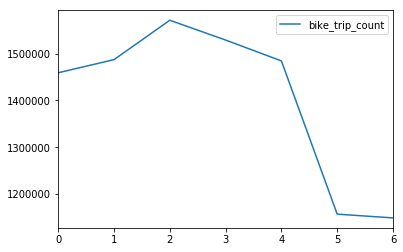

In [50]:
agg = citi_df_all_day.groupby(['day_of_week'], as_index=False)['bikeid'].count()
agg.columns = ['day_of_week', 'bike_trip_count']
agg[['bike_trip_count']].plot()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


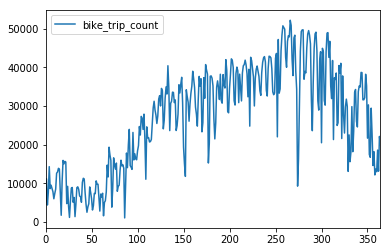

In [168]:
citi_df_day_agg.sort('bike_date', inplace=True)
citi_df_day_agg[['bike_date', 'bike_trip_count']].plot()

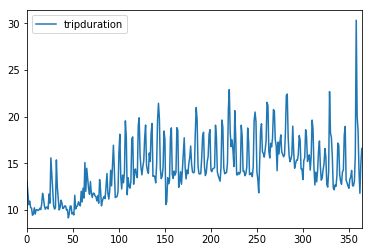

In [169]:
citi_df_day_agg[['bike_date', 'tripduration']].plot()

## Clustering Anomaly Detection

### K-means Anomaly Detection

In [172]:
cluster_features = ['bike_trip_count', 'tripduration']

In [173]:
X = citi_df_day_agg[cluster_features]
X.head(2)

,bike_trip_count,tripduration
0,5232,13.061735
1,11183,11.813467


In [174]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()
    
X.head()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,bike_trip_count,tripduration
0,-1.626679,-0.460979
1,-1.180955,-0.867642
2,-1.687572,-1.276046
3,-1.436810,-1.153334
4,-0.945098,-1.378537


In [175]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.526677191417
For n_clusters =3, the average silhouette_score is :0.555579974002
For n_clusters =4, the average silhouette_score is :0.466739328951
For n_clusters =5, the average silhouette_score is :0.483612503495
For n_clusters =6, the average silhouette_score is :0.478796284289
For n_clusters =7, the average silhouette_score is :0.477565435193
For n_clusters =8, the average silhouette_score is :0.465294222423


In [176]:
n=3
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [177]:
citi_df_day_agg['cluster'] = res.cluster
citi_df_day_agg['km_score'] = res.score
citi_df_day_agg['outlier'] = 0
citi_df_day_agg.sort_values("km_score",ascending=False, inplace=True)

In [178]:
citi_df_day_agg.head(10)

,bike_date,holiday,weekend,bike_trip_count,tripduration,cluster,km_score,outlier,color
358,2015-12-25,1,1,12188,30.319905,2,3.957027,0,red
329,2015-11-26,1,0,13106,22.674729,2,1.698349,0,red
26,2015-01-27,0,0,1204,15.568937,0,1.523237,0,red
274,2015-10-02,0,1,9297,15.985587,0,1.461588,0,red
32,2015-02-02,0,0,1409,15.348474,0,1.453597,0,red
283,2015-10-11,1,0,38592,22.411018,2,1.444202,0,red
261,2015-09-19,0,1,42604,21.520890,2,1.429960,0,red
267,2015-09-25,0,1,50842,17.689725,1,1.417362,0,red
282,2015-10-10,0,1,38947,22.245847,2,1.415140,0,red
220,2015-08-09,0,0,32395,22.888563,2,1.398363,0,red


In [179]:
citi_df_day_agg['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [180]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "purple"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_day_agg = citi_df_day_agg.assign(color=citi_df_day_agg.apply(set_color, axis=1))

In [181]:
citi_df_day_agg_w_z_scores = citi_df_day_agg.merge(X, left_index=True, right_index=True)

In [182]:
citi_df_day_agg_w_z_scores.sort_values("km_score",ascending=False, inplace=True)
citi_df_day_agg_w_z_scores[['bike_date', 'km_score',  'bike_trip_count_x',\
                          'tripduration_x', \
                                    'bike_trip_count_y', 'tripduration_y']].head(15)

,bike_date,km_score,bike_trip_count_x,tripduration_x,bike_trip_count_y,tripduration_y
358,2015-12-25,3.957027,12188,30.319905,-1.105681,5.161421
329,2015-11-26,1.698349,13106,22.674729,-1.036924,2.670761
26,2015-01-27,1.523237,1204,15.568937,-1.928372,0.355822
274,2015-10-02,1.461588,9297,15.985587,-1.322214,0.491559
32,2015-02-02,1.453597,1409,15.348474,-1.913018,0.283999
283,2015-10-11,1.444202,38592,22.411018,0.871953,2.584848
261,2015-09-19,1.429960,42604,21.520890,1.172448,2.294861
267,2015-09-25,1.417362,50842,17.689725,1.789467,1.046736
282,2015-10-10,1.415140,38947,22.245847,0.898543,2.531039
220,2015-08-09,1.398363,32395,22.888563,0.407804,2.740424


In [183]:
X.head()

,bike_trip_count,tripduration
0,-1.626679,-0.460979
1,-1.180955,-0.867642
2,-1.687572,-1.276046
3,-1.436810,-1.153334
4,-0.945098,-1.378537


In [184]:
citi_df_day_agg.head()

,bike_date,holiday,weekend,bike_trip_count,tripduration,cluster,km_score,outlier,color
358,2015-12-25,1,1,12188,30.319905,2,3.957027,1,red
329,2015-11-26,1,0,13106,22.674729,2,1.698349,1,red
26,2015-01-27,0,0,1204,15.568937,0,1.523237,1,red
274,2015-10-02,0,1,9297,15.985587,0,1.461588,1,red
32,2015-02-02,0,0,1409,15.348474,0,1.453597,1,red


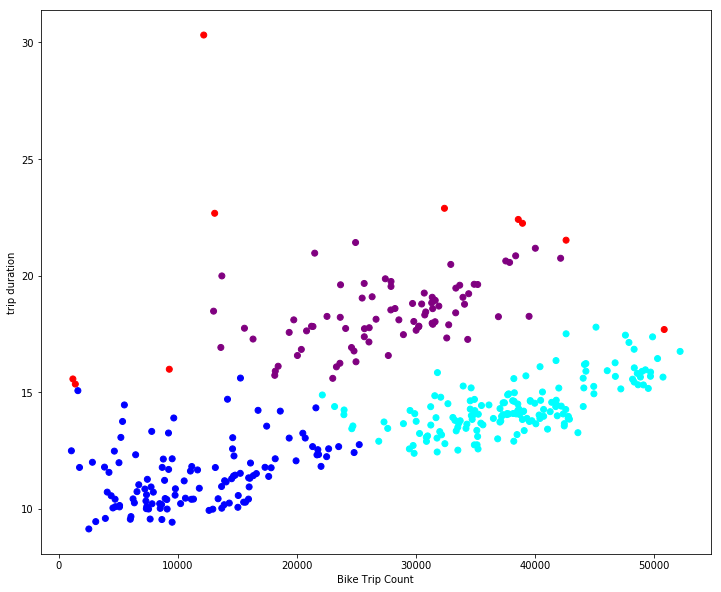

In [186]:
fig = plt.figure(figsize=(12,10))
#ax = Axes2D(fig)

plt.scatter(citi_df_day_agg.bike_trip_count, citi_df_day_agg.tripduration, c=citi_df_day_agg.color)
plt.xlabel('Bike Trip Count')
plt.ylabel('trip duration')
# set x ticks and labels
#plt.set_xticks(range(-2, 3, 1))
# change fontsize
#for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Isolation Anomaly Detection

### Isolation Forest Anomaly Detection

In [67]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [68]:
citi_df_day_agg_w_z_scores['decision_function'] = clf.decision_function(X)

In [69]:
citi_df_day_agg_w_z_scores.sort_values(by='decision_function').head(10)

,bike_date,holiday,weekend,bike_trip_count_x,tripduration_x,cluster,km_score,outlier,color,bike_trip_count_y,tripduration_y,decision_function
319,2015-11-16,0,0,40469,14.650621,1,0.176104,0,cyan,1.012539,0.056651,-0.150909
164,2015-06-14,0,0,27892,18.528718,2,0.063236,0,purple,0.070534,1.320065,-0.150070
289,2015-10-17,0,1,31477,18.967405,2,0.279924,0,purple,0.339047,1.462981,-0.126351
205,2015-07-25,0,1,31369,19.072173,2,0.284053,0,purple,0.330958,1.497113,-0.114612
245,2015-09-03,0,0,42451,13.553155,1,0.419483,0,cyan,1.160989,-0.300883,-0.112127
156,2015-06-06,0,1,26079,17.766249,2,0.340002,0,purple,-0.065258,1.071666,-0.109506
212,2015-08-01,0,1,34890,19.629550,2,0.601505,0,purple,0.594677,1.678696,-0.099511
211,2015-07-31,0,1,38244,14.608331,1,0.059930,0,cyan,0.845889,0.042874,-0.098715
305,2015-11-02,0,0,44095,15.183513,1,0.497332,0,cyan,1.284123,0.230258,-0.087963
325,2015-11-22,0,0,23018,15.595143,2,1.082420,0,purple,-0.294524,0.364359,-0.087808


In [70]:
citi_df_day_agg_w_z_scores_final = citi_df_day_agg_w_z_scores[['bike_date', 'km_score', 'decision_function', 'bike_trip_count_x',\
                          'tripduration_x', \
                                    'bike_trip_count_y', 'tripduration_y',]]
citi_df_day_agg_w_z_scores_final.head()

,bike_date,km_score,decision_function,bike_trip_count_x,tripduration_x,bike_trip_count_y,tripduration_y
358,2015-12-25,3.957027,-0.007943,12188,30.319905,-1.105681,5.161421
329,2015-11-26,1.698349,0.029277,13106,22.674729,-1.036924,2.670761
26,2015-01-27,1.523237,0.005273,1204,15.568937,-1.928372,0.355822
274,2015-10-02,1.461588,0.030392,9297,15.985587,-1.322214,0.491559
32,2015-02-02,1.453597,0.013945,1409,15.348474,-1.913018,0.283999


In [71]:
citi_df_day_agg_w_z_scores_final.sort_values("km_score",ascending=False, inplace=True)
citi_df_day_agg_w_z_scores_final.to_csv('citi_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Look at specific areas and see what times / dates around there are anomalies
### Madison Square Gardens (40.750556, -73.993611)

In [187]:
latlon_list = [40.750556, -73.993611]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
citi_df_total_subset = citi_df_all_day_agg[(citi_df_all_day_agg['start station latitude'] > (latlon_list[0] - 0.005)) & (citi_df_all_day_agg['start station latitude'] < (latlon_list[0] + 0.005))]
citi_df_total_subset = citi_df_total_subset[(citi_df_total_subset['start station longitude'] > (latlon_list[1] - 0.005)) & (citi_df_total_subset['start station longitude'] < (latlon_list[1] + 0.005))]

In [188]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(citi_df_total_subset['start station longitude'], citi_df_total_subset['start station latitude'])]

In [189]:
crs = {'init': 'epsg:4326'}
citi_df_total_subset = GeoDataFrame(citi_df_total_subset, crs=crs, geometry=geometry)

In [190]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [191]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.98861100000001 40.750556, -73.98..."


In [192]:
# only keep points within MSG buffer
citi_df_total_subset = citi_df_total_subset[citi_df_total_subset.geometry.intersects(MSG_gp.geometry[0])]

In [193]:
#take the mean of the taxi stats each day / hour
citi_df_MSG_mean = citi_df_total_subset.groupby(['bike_date'], as_index=False).mean()
citi_df_MSG_mean.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1.0,0.0,481.625,40.750011,-73.994025,22.500,13.264523
1,2015-01-02,1.0,1.0,481.625,40.750011,-73.994025,66.125,10.106404
2,2015-01-03,0.0,1.0,481.625,40.750011,-73.994025,19.625,9.091219
3,2015-01-04,0.0,0.0,481.625,40.750011,-73.994025,34.125,9.358956
4,2015-01-05,0.0,0.0,481.625,40.750011,-73.994025,136.125,9.178132


In [194]:
citi_df_MSG_mean['day_of_week'] = citi_df_MSG_mean.bike_date.apply(lambda x: x.weekday())

In [195]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [196]:
citi_df_total_subset

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration,geometry
158,2015-01-01,1,0,379.0,40.749156,-73.991600,15,16.266667,POINT (-73.99160000000001 40.749156)
216,2015-01-01,1,0,442.0,40.746647,-73.993915,19,12.368421,POINT (-73.993915 40.746647)
262,2015-01-01,1,0,490.0,40.751551,-73.993934,27,12.592593,POINT (-73.993934 40.751551)
264,2015-01-01,1,0,492.0,40.750200,-73.990931,19,9.000000,POINT (-73.99093085 40.75019995)
266,2015-01-01,1,0,494.0,40.747348,-73.997236,19,6.947368,POINT (-73.99723551 40.74734825)
283,2015-01-01,1,0,512.0,40.750073,-73.998393,19,10.052632,POINT (-73.99839279 40.7500727)
292,2015-01-01,1,0,521.0,40.750450,-73.994811,41,12.317073,POINT (-73.99481050999999 40.75044999)
294,2015-01-01,1,0,523.0,40.754666,-73.991382,21,26.571429,POINT (-73.99138152 40.75466591)
485,2015-01-02,1,1,379.0,40.749156,-73.991600,65,8.553846,POINT (-73.99160000000001 40.749156)
542,2015-01-02,1,1,442.0,40.746647,-73.993915,71,10.901408,POINT (-73.993915 40.746647)


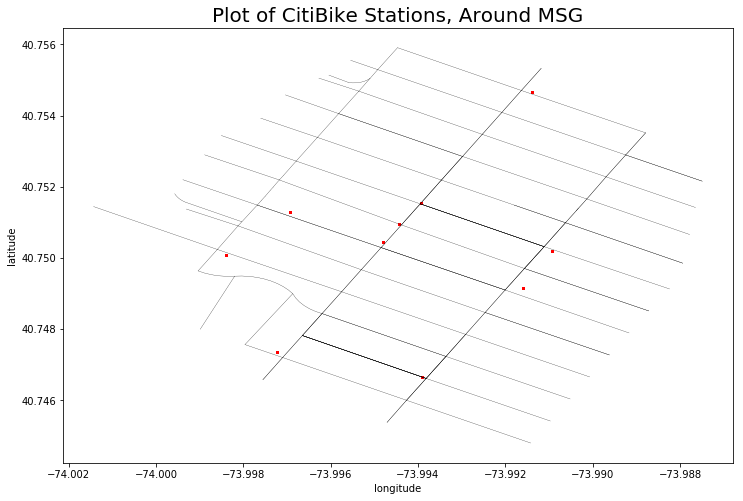

In [197]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = citi_df_total_subset.sample(n=1000)
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of CitiBike Stations, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [198]:
citi_df_day_mean_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_count_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bike_trip_count'].sum()
citi_df_agg_subset = citi_df_count_subset.merge(citi_df_day_mean_subset)
citi_df_agg_subset.head()

,bike_date,holiday,weekend,bike_trip_count,tripduration
0,2015-01-01,1,0,180,13.264523
1,2015-01-02,1,1,529,10.106404
2,2015-01-03,0,1,157,9.091219
3,2015-01-04,0,0,273,9.358956
4,2015-01-05,0,0,1089,9.178132


In [199]:
X = citi_df_agg_subset[cluster_features]
X.head(2)

,bike_trip_count,tripduration
0,180,13.264523
1,529,10.106404


In [200]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [201]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [202]:
citi_df_agg_subset['decision_function'] = clf.decision_function(X)

In [203]:
citi_df_agg_subset.sort_values(by='decision_function').head(10)

,bike_date,holiday,weekend,bike_trip_count,tripduration,decision_function
26,2015-01-27,0,0,45,25.491319,-0.187906
27,2015-01-28,0,0,341,32.490262,-0.173549
28,2015-01-29,0,0,544,30.964135,-0.162438
358,2015-12-25,1,1,276,23.850907,-0.147475
226,2015-08-15,0,1,942,21.755302,-0.121814
73,2015-03-15,0,0,297,19.374269,-0.115417
282,2015-10-10,0,1,1050,20.374951,-0.114552
329,2015-11-26,1,0,485,21.164137,-0.114162
220,2015-08-09,0,0,972,21.178036,-0.106177
32,2015-02-02,0,0,79,16.155464,-0.086208


### K-Means Cluster Model Anomaly Detection

In [204]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.467495762681
For n_clusters =3, the average silhouette_score is :0.572478115622
For n_clusters =4, the average silhouette_score is :0.582169085699
For n_clusters =5, the average silhouette_score is :0.562742436005
For n_clusters =6, the average silhouette_score is :0.511302651313
For n_clusters =7, the average silhouette_score is :0.443365732366
For n_clusters =8, the average silhouette_score is :0.435351527365


In [205]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [206]:
KM.cluster_centers_

array([[-0.65844133,  0.65036205],
       [ 1.02843005, -0.09346734],
       [-0.90135959, -0.87546124],
       [-1.38231219,  5.14988686],
       [-0.66729412,  2.01159815]])

In [207]:
citi_df_agg_subset['cluster'] = res.cluster
citi_df_agg_subset['km_score'] = res.score
citi_df_agg_subset['outlier'] = 0
citi_df_agg_subset.sort_values("km_score",ascending=False, inplace=True)

In [208]:
citi_df_agg_subset['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [209]:
citi_df_agg_subset.tail()

,bike_date,holiday,weekend,bike_trip_count,tripduration,decision_function,cluster,km_score,outlier
195,2015-07-15,0,0,1994,12.362948,0.097078,1,0.060247,0
235,2015-08-24,0,0,1982,12.350958,0.098635,1,0.056970,0
211,2015-07-31,0,1,1942,12.622567,0.091869,1,0.055951,0
185,2015-07-05,0,0,777,18.781322,-0.047521,4,0.030524,0
204,2015-07-24,0,1,1989,12.543564,0.094548,1,0.026511,0


In [210]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "pink"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_agg_subset = citi_df_agg_subset.assign(color=citi_df_agg_subset.apply(set_color, axis=1))

In [211]:
X.sort_values("tripduration",ascending=False, inplace=True)

In [212]:
citi_df_total_subset_w_z_scores = citi_df_agg_subset.merge(X, left_index=True, right_index=True)
z_score = citi_df_total_subset_w_z_scores[['bike_date', 'km_score',  'tripduration_x',\
                          'bike_trip_count_x', \
                                    'tripduration_y', 'bike_trip_count_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('citi_MSG_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [213]:
z_score.head(10)

,bike_date,km_score,tripduration_x,bike_trip_count_x,tripduration_y,bike_trip_count_y
358,2015-12-25,1.454179,23.850907,276,3.696173,-1.419116
27,2015-01-28,1.435742,32.490262,341,6.584496,-1.325302
126,2015-05-07,1.401585,16.704212,1931,1.306879,0.969526
267,2015-09-25,1.308277,16.428117,1989,1.214575,1.053237
32,2015-02-02,1.147090,16.155464,79,1.123421,-1.703444
279,2015-10-07,1.143861,14.905294,2539,0.705462,1.847045
223,2015-08-12,1.056219,15.375022,2283,0.862503,1.477563
25,2015-01-26,1.049068,12.738379,215,-0.018984,-1.507157
103,2015-04-14,1.034090,11.176097,1326,-0.541289,0.096337
0,2015-01-01,1.025721,13.264523,180,0.156917,-1.557672


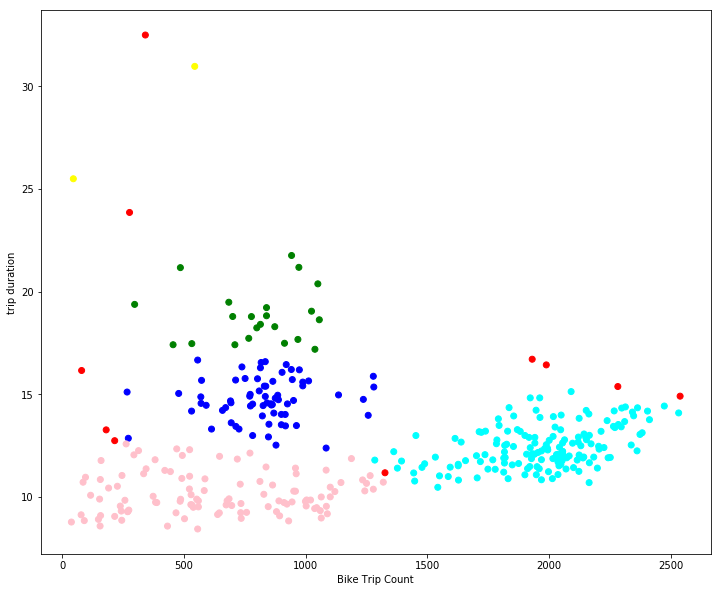

In [214]:
fig = plt.figure(figsize=(12,10))
#ax = Axes2D(fig)

plt.scatter(citi_df_agg_subset.bike_trip_count, citi_df_agg_subset.tripduration, c=citi_df_agg_subset.color)
plt.xlabel('Bike Trip Count')
plt.ylabel('trip duration')
# set x ticks and labels
#plt.set_xticks(range(-2, 3, 1))
# change fontsize
#for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### staten island ferry terminal (Whitehall between state & FDR) (40.702095, -74.012782)

In [106]:
latlon_list = [40.702095, -74.012782]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
citi_df_total_subset = citi_df_all_day_agg[(citi_df_all_day_agg['start station latitude'] > (latlon_list[0] - 0.005)) & (citi_df_all_day_agg['start station latitude'] < (latlon_list[0] + 0.005))]
citi_df_total_subset = citi_df_total_subset[(citi_df_total_subset['start station longitude'] > (latlon_list[1] - 0.005)) & (citi_df_total_subset['start station longitude'] < (latlon_list[1] + 0.005))]

In [107]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(citi_df_total_subset['start station longitude'], citi_df_total_subset['start station latitude'])]

In [108]:
crs = {'init': 'epsg:4326'}
citi_df_total_subset = GeoDataFrame(citi_df_total_subset, crs=crs, geometry=geometry)

In [109]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [110]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-74.00778200000001 40.702095, -74.00..."


In [111]:
# only keep points within MSG buffer
citi_df_total_subset = citi_df_total_subset[citi_df_total_subset.geometry.intersects(MSG_gp.geometry[0])]

In [112]:
#take the mean of the taxi stats each day / hour
citi_df_MSG_mean = citi_df_total_subset.groupby(['bike_date'], as_index=False).mean()
citi_df_MSG_mean.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1.0,0.0,362.285714,40.703212,-74.011707,6.428571,16.319625
1,2015-01-02,1.0,1.0,362.285714,40.703212,-74.011707,17.000000,14.835784
2,2015-01-03,0.0,1.0,362.285714,40.703212,-74.011707,3.714286,12.814286
3,2015-01-04,0.0,0.0,362.285714,40.703212,-74.011707,7.142857,17.580612
4,2015-01-05,0.0,0.0,362.285714,40.703212,-74.011707,26.285714,13.126105


In [113]:
citi_df_MSG_mean['day_of_week'] = citi_df_MSG_mean.bike_date.apply(lambda x: x.weekday())

In [114]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [115]:
citi_df_total_subset

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration,geometry
56,2015-01-01,1,0,259.0,40.701221,-74.012342,5,19.200000,POINT (-74.01234218 40.70122128)
57,2015-01-01,1,0,260.0,40.703652,-74.011678,6,19.833333,POINT (-74.01167796999999 40.70365182)
91,2015-01-01,1,0,304.0,40.704633,-74.013617,9,9.888889,POINT (-74.01361706 40.70463334)
122,2015-01-01,1,0,337.0,40.703799,-74.008387,5,24.800000,POINT (-74.00838675999999 40.70379920000001)
192,2015-01-01,1,0,415.0,40.704718,-74.009260,11,8.181818,POINT (-74.00926027 40.7047177)
202,2015-01-01,1,0,427.0,40.701907,-74.013942,6,15.666667,POINT (-74.013942 40.701907)
305,2015-01-01,1,0,534.0,40.702551,-74.012723,3,16.666667,POINT (-74.0127234 40.70255065)
383,2015-01-02,1,1,259.0,40.701221,-74.012342,11,18.727273,POINT (-74.01234218 40.70122128)
384,2015-01-02,1,1,260.0,40.703652,-74.011678,9,12.333333,POINT (-74.01167796999999 40.70365182)
418,2015-01-02,1,1,304.0,40.704633,-74.013617,26,18.384615,POINT (-74.01361706 40.70463334)


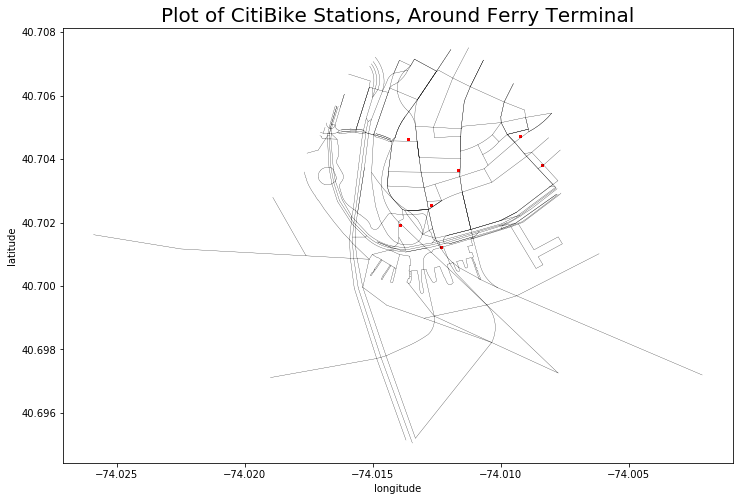

In [116]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = citi_df_total_subset.sample(n=1000)
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of CitiBike Stations, Around Ferry Terminal", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [117]:
citi_df_day_mean_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_count_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bike_trip_count'].sum()
citi_df_agg_subset = citi_df_count_subset.merge(citi_df_day_mean_subset)
citi_df_agg_subset.head()

,bike_date,holiday,weekend,bike_trip_count,tripduration
0,2015-01-01,1,0,45,16.319625
1,2015-01-02,1,1,119,14.835784
2,2015-01-03,0,1,26,12.814286
3,2015-01-04,0,0,50,17.580612
4,2015-01-05,0,0,184,13.126105


In [118]:
X = citi_df_agg_subset[cluster_features]
X.head(2)

,bike_trip_count,tripduration
0,45,16.319625
1,119,14.835784


In [119]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [138]:
citi_df_agg_subset['bike_trip_count'].mean()

353.60547945205479

In [139]:
citi_df_agg_subset['bike_trip_count'].std()

204.54792816097665

In [120]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [121]:
citi_df_agg_subset['decision_function'] = clf.decision_function(X)

In [122]:
citi_df_agg_subset.sort_values(by='decision_function').head(10)

,bike_date,holiday,weekend,bike_trip_count,tripduration,decision_function
177,2015-06-27,0,1,156,128.381174,-0.203962
317,2015-11-14,0,1,207,60.529173,-0.145757
359,2015-12-26,1,1,148,55.541667,-0.137788
86,2015-03-28,0,1,6,40.625000,-0.119763
358,2015-12-25,1,1,222,49.450667,-0.111572
233,2015-08-22,0,1,476,42.795034,-0.096991
268,2015-09-26,0,1,566,36.476350,-0.081138
346,2015-12-13,0,0,302,41.349671,-0.080653
32,2015-02-02,0,0,11,9.812500,-0.073448
263,2015-09-21,0,0,714,29.272238,-0.071919


### K-Means Cluster Model Anomaly Detection

In [123]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.514047557755
For n_clusters =3, the average silhouette_score is :0.524916444689
For n_clusters =4, the average silhouette_score is :0.523330288453
For n_clusters =5, the average silhouette_score is :0.45047083616
For n_clusters =6, the average silhouette_score is :0.436178327687
For n_clusters =7, the average silhouette_score is :0.445428546488
For n_clusters =8, the average silhouette_score is :0.409380723581


In [124]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [125]:
citi_df_agg_subset['cluster'] = res.cluster
citi_df_agg_subset['km_score'] = res.score
citi_df_agg_subset['outlier'] = 0
citi_df_agg_subset.sort_values("km_score",ascending=False, inplace=True)

In [126]:
citi_df_agg_subset['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [127]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "pink"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_agg_subset = citi_df_agg_subset.assign(color=citi_df_agg_subset.apply(set_color, axis=1))

In [128]:
X.sort_values("tripduration",ascending=False, inplace=True)

In [133]:
citi_df_total_subset_w_z_scores

,bike_date,holiday,weekend,bike_trip_count_x,tripduration_x,decision_function,cluster,km_score,outlier,color,bike_trip_count_y,tripduration_y
177,2015-06-27,0,1,156,128.381174,-0.203962,4,0.000000,0,green,-0.966060,12.410205
317,2015-11-14,0,1,207,60.529173,-0.145757,2,2.377158,1,red,-0.716729,4.577701
359,2015-12-26,1,1,148,55.541667,-0.137788,2,1.894936,1,red,-1.005170,4.001968
358,2015-12-25,1,1,222,49.450667,-0.111572,2,1.112198,1,red,-0.643397,3.298852
233,2015-08-22,0,1,476,42.795034,-0.096991,2,0.971352,0,pink,0.598366,2.530559
346,2015-12-13,0,0,302,41.349671,-0.080653,2,0.150321,0,pink,-0.252290,2.363713
86,2015-03-28,0,1,6,40.625000,-0.119763,2,1.373962,1,red,-1.699384,2.280060
255,2015-09-13,0,0,401,38.440993,-0.058259,2,0.594368,0,pink,0.231704,2.027949
311,2015-11-08,0,0,278,37.223357,-0.056723,2,0.348158,0,pink,-0.369622,1.887391
268,2015-09-26,0,1,566,36.476350,-0.081138,2,1.431245,1,red,1.038361,1.801160


In [134]:
citi_df_total_subset_w_z_scores = citi_df_agg_subset.merge(X, left_index=True, right_index=True)
z_score = citi_df_total_subset_w_z_scores[['bike_date', 'km_score', 'decision_function', 'tripduration_x',\
                          'bike_trip_count_x', 'tripduration_y', 'bike_trip_count_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('citi_ferry_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [166]:
z_score.head()

,bike_date,km_score,tripduration_x,bike_trip_count_x,tripduration_y,bike_trip_count_y
292,2015-10-20,1.136252,16.424330,1277,-0.016994,2.655840
294,2015-10-22,0.888684,15.244182,1205,-0.041016,2.408917
293,2015-10-21,0.713599,14.695526,1154,-0.052184,2.234013
128,2015-05-09,0.682992,46.654257,263,0.598339,-0.821657
65,2015-03-07,0.609835,41.572562,50,0.494901,-1.552138


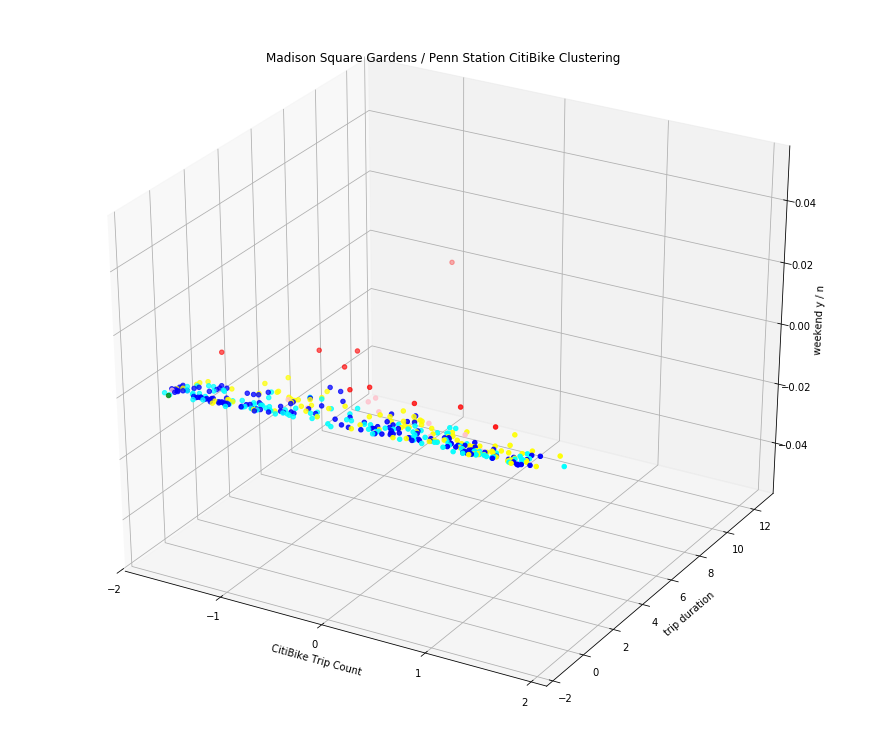

In [131]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.tripduration, c=citi_df_agg_subset.color)
ax.set_title('Madison Square Gardens / Penn Station CitiBike Clustering')
ax.set_xlabel('CitiBike Trip Count')
ax.set_ylabel('trip duration')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-2, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### St. Patricks Cathedral (40.758477, -73.976223)

In [140]:
latlon_list = [40.758477, -73.976223]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
citi_df_total_subset = citi_df_all_day_agg[(citi_df_all_day_agg['start station latitude'] > (latlon_list[0] - 0.005)) & (citi_df_all_day_agg['start station latitude'] < (latlon_list[0] + 0.005))]
citi_df_total_subset = citi_df_total_subset[(citi_df_total_subset['start station longitude'] > (latlon_list[1] - 0.005)) & (citi_df_total_subset['start station longitude'] < (latlon_list[1] + 0.005))]

In [141]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(citi_df_total_subset['start station longitude'], citi_df_total_subset['start station latitude'])]

In [142]:
crs = {'init': 'epsg:4326'}
citi_df_total_subset = GeoDataFrame(citi_df_total_subset, crs=crs, geometry=geometry)

In [143]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [144]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.97122300000001 40.758477, -73.97..."


In [145]:
# only keep points within MSG buffer
citi_df_total_subset = citi_df_total_subset[citi_df_total_subset.geometry.intersects(MSG_gp.geometry[0])]

In [146]:
#take the mean of the taxi stats each day / hour
citi_df_MSG_mean = citi_df_total_subset.groupby(['bike_date'], as_index=False).mean()
citi_df_MSG_mean.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1.0,0.0,434.571429,40.75869,-73.975372,5.142857,20.935714
1,2015-01-02,1.0,1.0,434.571429,40.75869,-73.975372,41.428571,15.530044
2,2015-01-03,0.0,1.0,434.571429,40.75869,-73.975372,3.714286,11.452381
3,2015-01-04,0.0,0.0,434.571429,40.75869,-73.975372,11.000000,11.777778
4,2015-01-05,0.0,0.0,434.571429,40.75869,-73.975372,55.142857,9.340835


In [147]:
citi_df_MSG_mean['day_of_week'] = citi_df_MSG_mean.bike_date.apply(lambda x: x.weekday())

In [148]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


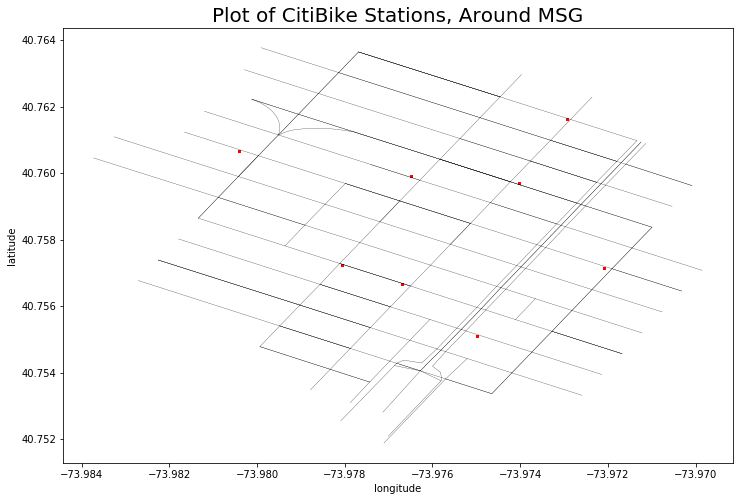

In [149]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = citi_df_total_subset.sample(n=1000)
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of CitiBike Stations, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [150]:
citi_df_day_mean_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_count_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bike_trip_count'].sum()
citi_df_agg_subset = citi_df_count_subset.merge(citi_df_day_mean_subset)
citi_df_agg_subset.head()

,bike_date,holiday,weekend,bike_trip_count,tripduration
0,2015-01-01,1,0,36,20.935714
1,2015-01-02,1,1,290,15.530044
2,2015-01-03,0,1,26,11.452381
3,2015-01-04,0,0,77,11.777778
4,2015-01-05,0,0,386,9.340835


In [151]:
X = citi_df_agg_subset[cluster_features]
X.head(2)

,bike_trip_count,tripduration
0,36,20.935714
1,290,15.530044


In [152]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [154]:
citi_df_agg_subset['decision_function'] = clf.decision_function(X)

In [155]:
citi_df_agg_subset.sort_values(by='decision_function').head(10)

,bike_date,holiday,weekend,bike_trip_count,tripduration,decision_function
65,2015-03-07,0,1,50,41.572562,-0.184816
220,2015-08-09,0,0,336,948.638551,-0.158126
128,2015-05-09,0,1,263,46.654257,-0.150047
143,2015-05-24,1,0,281,33.126045,-0.115676
219,2015-08-08,0,1,768,27.031389,-0.109063
226,2015-08-15,0,1,757,26.520119,-0.105048
144,2015-05-25,1,0,392,30.679370,-0.100166
278,2015-10-06,0,0,1044,20.262781,-0.096966
292,2015-10-20,0,0,1277,16.424330,-0.095491
212,2015-08-01,0,1,684,26.891312,-0.094883


### K-Means Cluster Model Anomaly Detection

In [156]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.936354901426
For n_clusters =3, the average silhouette_score is :0.672676334422
For n_clusters =4, the average silhouette_score is :0.550385344905
For n_clusters =5, the average silhouette_score is :0.51700453053
For n_clusters =6, the average silhouette_score is :0.510584316075
For n_clusters =7, the average silhouette_score is :0.498907941715
For n_clusters =8, the average silhouette_score is :0.474049021593


In [157]:
X.head()

,bike_trip_count,tripduration
0,-1.600150,0.074836
1,-0.729061,-0.035197
2,-1.634445,-0.118198
3,-1.459542,-0.111575
4,-0.399831,-0.161179


In [158]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [159]:
citi_df_agg_subset['cluster'] = res.cluster
citi_df_agg_subset['km_score'] = res.score
citi_df_agg_subset['outlier'] = 0
citi_df_agg_subset.sort_values("km_score",ascending=False, inplace=True)

In [160]:
citi_df_agg_subset['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [161]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "pink"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_agg_subset = citi_df_agg_subset.assign(color=citi_df_agg_subset.apply(set_color, axis=1))

In [162]:
#X.sort_values("tripduration",ascending=False, inplace=True)

In [163]:
citi_df_total_subset_w_z_scores = citi_df_agg_subset.merge(X, left_index=True, right_index=True)
z_score = citi_df_total_subset_w_z_scores[['bike_date', 'km_score',  'tripduration_x',\
                          'bike_trip_count_x', \
                                    'tripduration_y', 'bike_trip_count_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('citi_patrick_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [164]:
X.head()

,bike_trip_count,tripduration
0,-1.600150,0.074836
1,-0.729061,-0.035197
2,-1.634445,-0.118198
3,-1.459542,-0.111575
4,-0.399831,-0.161179


AttributeError: 'DataFrame' object has no attribute 'weekend'

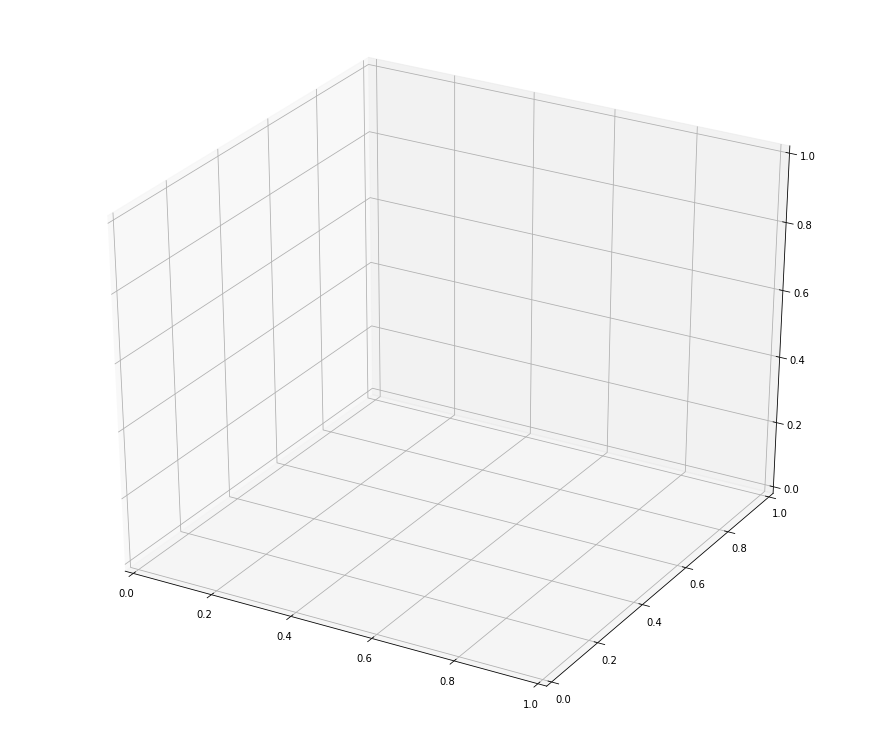

In [165]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.tripduration, X.weekend, c=citi_df_agg_subset.color)
ax.set_xlabel('CitiBike Trip Count')
ax.set_ylabel('trip duration')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-2, 5, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### Metropolitan Opera (40.772567, -73.984089)

In [ ]:
latlon_list = [40.772567, -73.984089]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
citi_df_total_subset = citi_df_all_day_agg[(citi_df_all_day_agg['start station latitude'] > (latlon_list[0] - 0.005)) & (citi_df_all_day_agg['start station latitude'] < (latlon_list[0] + 0.005))]
citi_df_total_subset = citi_df_total_subset[(citi_df_total_subset['start station longitude'] > (latlon_list[1] - 0.005)) & (citi_df_total_subset['start station longitude'] < (latlon_list[1] + 0.005))]

In [ ]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(citi_df_total_subset['start station longitude'], citi_df_total_subset['start station latitude'])]

In [ ]:
crs = {'init': 'epsg:4326'}
citi_df_total_subset = GeoDataFrame(citi_df_total_subset, crs=crs, geometry=geometry)

In [ ]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [ ]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

In [ ]:
# only keep points within MSG buffer
citi_df_total_subset = citi_df_total_subset[citi_df_total_subset.geometry.intersects(MSG_gp.geometry[0])]

In [ ]:
#take the mean of the taxi stats each day / hour
citi_df_MSG_mean = citi_df_total_subset.groupby(['bike_date'], as_index=False).mean()
citi_df_MSG_mean.head()

In [ ]:
citi_df_MSG_mean['day_of_week'] = citi_df_MSG_mean.bike_date.apply(lambda x: x.weekday())

In [ ]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [ ]:
citi_df_total_subset

In [ ]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = citi_df_total_subset.sample(n=1000)
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of CitiBike Stations, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [ ]:
citi_df_day_mean_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_count_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bike_trip_count'].sum()
citi_df_agg_subset = citi_df_count_subset.merge(citi_df_day_mean_subset)
citi_df_agg_subset.head()

In [ ]:
X = citi_df_agg_subset[cluster_features]
X.head(2)

In [ ]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

In [ ]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [ ]:
citi_df_agg_subset['decision_function'] = clf.decision_function(X)

In [ ]:
citi_df_agg_subset.sort_values(by='decision_function').head(10)

### K-Means Cluster Model Anomaly Detection

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

In [ ]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [ ]:
citi_df_agg_subset['cluster'] = res.cluster
citi_df_agg_subset['km_score'] = res.score
citi_df_agg_subset['outlier'] = 0
citi_df_agg_subset.sort_values("km_score",ascending=False, inplace=True)

In [ ]:
citi_df_agg_subset['outlier'][:10] = 1 

In [ ]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "pink"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_agg_subset = citi_df_agg_subset.assign(color=citi_df_agg_subset.apply(set_color, axis=1))

In [ ]:
X.sort_values("tripduration",ascending=False, inplace=True)

In [ ]:
citi_df_total_subset_w_z_scores = citi_df_agg_subset.merge(X, left_index=True, right_index=True)
z_score = citi_df_total_subset_w_z_scores[['bike_date', 'km_score',  'tripduration_x',\
                          'bike_trip_count_x', \
                                    'tripduration_x', 'bike_trip_count_x']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('citi_met_clustered_by_day_w_z_scores.csv')

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.tripduration, X.weekend, c=citi_df_agg_subset.color)
ax.set_title('Metropolitan Opera Clustering for CitiBike')
ax.set_xlabel('CitiBike Trip Count')
ax.set_ylabel('trip duration')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-2, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()